In [1]:
import pandas as pd
import numpy as np
import os
%load_ext autoreload
%autoreload 2
from src.model.one_class import DeepSVDD
from src.model.reconstruction import DAGMM
from src.trainer.ids import DeepSVDDIDSTrainer, DAGMMIDSTrainer
from src.utils import metrics
from src.utils.utils import ids_misclf_per_label
from src.datamanager.dataset import IDS2017Dataset
from src.bootstrap import store_results, load_from_ckpt
from datetime import datetime as dt

In [6]:
# Setup base folder structure
dataset_path = "../data/IDS2017/ids2017.csv"
export_path = "./%s" % dt.now().strftime("%m-%d-%Y_%H-%M-%S")
if not os.path.exists(export_path):
    os.mkdir(export_path)

# General arguments
batch_size = 1024
device = "cuda"
act_fn = "relu"
n_layers = 4
compression_factor = 2
lr = 1e-4
n_epochs = 200

# DeepSVDD-specific arguments
dsvdd_best_epoch = 106

# DAGMM-specific arguments
n_mixtures = 4
latent_dim = 1
lambda_1 = 0.005
lambda_2 = 0.1
reg_covar=1e-6
dagmm_best_epoch = 11

print("arguments set")

arguments set


In [3]:
dataset = IDS2017Dataset(path=dataset_path)
train_ldr, test_ldr = dataset.loaders(batch_size=batch_size, seed=42)
print("data loaded")

data loaded


## DeepSVDD Training

In [4]:
dsvdd_model = DeepSVDD(
    in_features=dataset.in_features,
    n_instances=dataset.n_instances,
    device=device,
    n_layers=n_layers,
    compression_factor=compression_factor,
    act_fn=act_fn,
)
dsvdd_trainer = DeepSVDDIDSTrainer(
    train_ldr=train_ldr,
    test_ldr=test_ldr,
    model=dsvdd_model,
    batch_size=batch_size,
    lr=lr,
    n_epochs=n_epochs,
    device=device,
    ckpt_fname=os.path.join(export_path, "deepsvdd")
)
print("DeepSVDD model and trainer ready")

DeepSVDD model and trainer ready


In [5]:
_ = dsvdd_trainer.train(train_ldr)
dsvdd_trainer.save_ckpt(os.path.join(export_path, "deepsvdd.pt"))

y_test_true, test_scores, test_labels = dsvdd_trainer.test(test_ldr)
results = metrics.estimate_optimal_threshold(test_scores, y_test_true)
y_pred = (test_scores >= results["Thresh_star"]).astype(int)
store_results(
    results=results,
    params=dict(batch_size=batch_size, lr=lr, n_epochs=n_epochs, **dsvdd_model.get_params()),
    model_name="DeepSVDD",
    dataset="IDS2017",
    dataset_path=dataset_path,
    results_path="./"
)
results

  1%|          | 6/1110 [00:00<00:34, 32.00it/s, epoch=1, loss=0.000]

Started training


100%|██████████| 1110/1110 [00:25<00:00, 43.99it/s, epoch=200, loss=0.000]


{'Precision': 0.5586405396883868,
 'Recall': 0.6418120553831035,
 'F1-Score': 0.5973450921256538,
 'AUPR': 0.7369894596347364,
 'AUROC': 0.8270542027936876,
 'Thresh_star': 5.083045095943817e-12,
 'Quantile_star': 62.18262734570128}

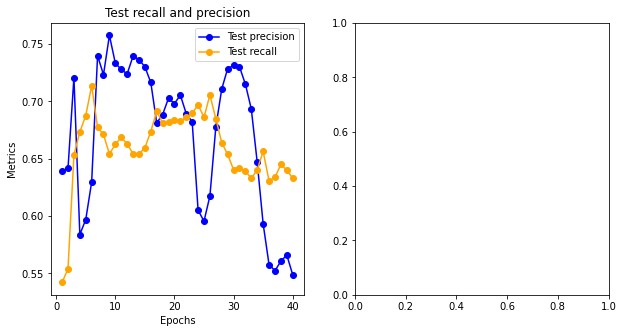

In [6]:
dsvdd_trainer.plot_metrics(export_path)

In [4]:
dsvdd_best_fname = "04-28-2022_14-59-02/checkpoints/deepsvdd_epoch=106"
dsvdd_trainer, dsvdd_model = DeepSVDDIDSTrainer.load_from_file(dsvdd_best_fname, dsvdd_trainer, dsvdd_model)
y_test_true, test_scores, test_labels = dsvdd_trainer.test(test_ldr)
results = metrics.estimate_optimal_threshold(test_scores, y_test_true)
y_pred = (test_scores >= results["Thresh_star"]).astype(int)
store_results(
    results=results,
    params=dict(batch_size=batch_size, lr=lr, n_epochs=106, **dsvdd_model.get_params()),
    model_name="DeepSVDD",
    dataset="IDS2017",
    dataset_path=dataset_path,
    results_path="./"
)
results

{'Precision': 0.6687775990141376,
 'Recall': 0.7006991928527749,
 'F1-Score': 0.6843663603651098,
 'AUPR': 0.7416159701117923,
 'AUROC': 0.7779861607717227,
 'Thresh_star': 3.871925002840726e-11,
 'Quantile_star': 65.5159606790346}

In [8]:
# Misclassified instances per label
misclf_df = ids_misclf_per_label(y_pred, y_test_true, test_labels)
misclf_df.to_csv(export_path + "/deepsvdd_misclassifications.csv")
misclf_df

,# Instances test set,Misclassified count,Misclassified ratio
BENIGN,1136374,193520,0.170296
Bot,1966,1864,0.948118
DDoS,128027,4381,0.034219
DoS,252658,68147,0.269720
FTP-Patator,7938,5419,0.682666
Heartbleed,11,0,0.000000
Infiltration,36,4,0.111111
PortScan,158930,79126,0.497867
SSH-Patator,5897,5873,0.995930
Web Attack,2180,2089,0.958257


## DAGMM Training

In [11]:
dagmm_model = DAGMM(
    in_features=dataset.in_features,
    n_instances=dataset.n_instances,
    device=device,
    n_mixtures=n_mixtures,
    latent_dim=latent_dim,
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    reg_covar=reg_covar,
    n_layers=n_layers,
    compression_factor=compression_factor,
    ae_act_fn="relu",
    gmm_act_fn="relu"
)
dagmm_trainer = DAGMMIDSTrainer(
    train_ldr=train_ldr,
    test_ldr=test_ldr,
    device=device,
    model=dagmm_model,
    batch_size=batch_size,
    lr=lr,
    n_epochs=n_epochs,
    ckpt_fname=os.path.join(export_path, "dagmm")
)
print("DAGMM model and trainer ready")

DAGMM model and trainer ready


In [8]:
train_ldr, test_ldr = dataset.loaders(batch_size=batch_size, seed=42)
dagmm_trainer.train(train_ldr)
y_test_true, test_scores, test_labels = dagmm_trainer.test(test_ldr)
results = metrics.estimate_optimal_threshold(test_scores, y_test_true)
y_pred = (test_scores >= results["Thresh_star"]).astype(int)
store_results(
    results=results,
    params=dict(batch_size=batch_size, lr=lr, n_epochs=n_epochs, **dagmm_model.get_params()),
    model_name="DAGMM",
    dataset="IDS2017",
    dataset_path=dataset_path,
    results_path=export_path
)
results

  0%|          | 1/1110 [00:00<02:37,  7.04it/s, epoch=1, loss=15737.304]

Started training


100%|██████████| 1110/1110 [02:00<00:00,  9.21it/s, epoch=200, loss=2.743]


{'Precision': 0.3325707374626279,
 'Recall': 0.2820585930425021,
 'F1-Score': 0.3052390429162352,
 'AUPR': 0.2758507352315302,
 'AUROC': 0.31253846380984696,
 'Thresh_star': 7.762237548828125,
 'Quantile_star': 72.08161724469117}

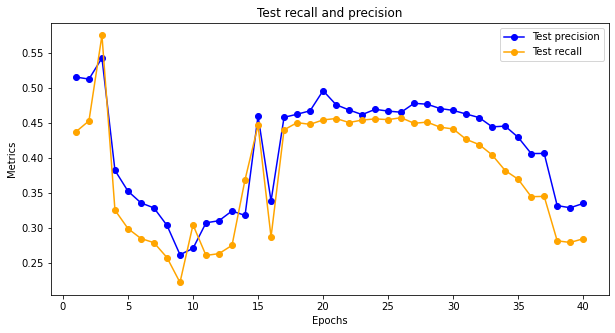

In [9]:
dagmm_trainer.plot_metrics(export_path)

In [13]:
dagmm_best = "04-28-2022_20-49-03/checkpoints/dagmm_epoch=11.pt"
dagmm_trainer, dagmm_model = load_from_ckpt(dagmm_best, dagmm_trainer, dagmm_model)
dagmm_trainer.n_epochs = dagmm_best_epoch
y_test_true, test_scores, test_labels = dagmm_trainer.test(test_ldr)
results = metrics.estimate_optimal_threshold(test_scores, y_test_true)
y_pred = (test_scores >= results["Thresh_star"]).astype(int)
store_results(
    results=results,
    params=dict(batch_size=batch_size, lr=lr, n_epochs=dagmm_best_epoch, **dagmm_model.get_params()),
    model_name="DAGMM",
    dataset="IDS2017",
    dataset_path=dataset_path,
    results_path="./"
)
results

TypeError: unsupported operand type(s) for +: 'NoneType' and 'Tensor'

In [ ]:
dagmm_misclf_df = ids_misclf_per_label(y_pred, y_test_true, test_labels)
dagmm_misclf_df.to_csv(export_path + "/dagmm_misclassifications.csv")
dagmm_misclf_df